In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os

import copy
import time
import pprint

import torch
import torchio as tio
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})
%config InlineBackend.figure_format = 'retina'
torch.manual_seed(14041931)

print('TorchIO version:', tio.__version__)
print('Last run on', time.ctime())


TorchIO version: 0.18.90
Last run on Tue Apr  4 16:33:17 2023


In [3]:
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt

In [4]:
#@title Visualization functions
def get_bounds(self):
    """Get image bounds in mm.

    Returns:
        np.ndarray: [description]
    """
    first_index = 3 * (-0.5,)
    last_index = np.array(self.spatial_shape) - 0.5
    first_point = nib.affines.apply_affine(self.affine, first_index)
    last_point = nib.affines.apply_affine(self.affine, last_index)
    array = np.array((first_point, last_point))
    bounds_x, bounds_y, bounds_z = array.T.tolist()
    return bounds_x, bounds_y, bounds_z

def to_pil(image):
    from PIL import Image
    from IPython.display import display
    data = image.numpy().squeeze().T
    data = data.astype(np.uint8)
    image = Image.fromarray(data)
    w, h = image.size
    display(image)
    print()  # in case multiple images are being displayed

def stretch(img):
    p1, p99 = np.percentile(img, (1, 99))
    from skimage import exposure
    img_rescale = exposure.rescale_intensity(img, in_range=(p1, p99))
    return img_rescale

def show_fpg(
        subject,
        to_ras=False,
        stretch_slices=True,
        indices=None,
        intensity_name='pet',
        parcellation=True,
        ):
    subject = tio.ToCanonical()(subject) if to_ras else subject
    def flip(x):
        return np.rot90(x)
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    if indices is None:
        half_shape = torch.Tensor(subject.spatial_shape) // 2
        i, j, k = half_shape.long()
        i -= 5  # use a better slice
    else:
        i, j, k = indices
    bounds_x, bounds_y, bounds_z = get_bounds(subject.pet)  ###

    orientation = ''.join(subject.pet.orientation)
    if orientation != 'RAS':
        import warnings
        warnings.warn(f'Image orientation should be RAS+, not {orientation}+')
    
    kwargs = dict(cmap='gray', interpolation='none')
    data = subject[intensity_name].data
    slices = data[0, i], data[0, :, j], data[0, ..., k]
    if stretch_slices:
        slices = [stretch(s.numpy()) for s in slices]
    sag, cor, axi = slices
    
    axes[0, 0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    axes[0, 1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    axes[0, 2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)
    
    data = subject['ct'].data
    slices = data[0, i], data[0, :, j], data[0, ..., k]
    if stretch_slices:
        slices = [stretch(s.numpy()) for s in slices]
    sag, cor, axi = slices
    
    axes[1, 0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    axes[1, 1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    axes[1, 2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)

    kwargs = dict(interpolation='none')
    data = subject.seg.data
    slices = data[0, i], data[0, :, j], data[0, ..., k]
    if parcellation:
        sag, cor, axi = [color_table.colorize(s.long()) if s.max() > 1 else s for s in slices]
    else:
        sag, cor, axi = slices
    axes[2, 0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    axes[2, 1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    axes[2, 2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)
    
    plt.tight_layout()


class ColorTable:
    def __init__(self, colors_path):
        self.df = self.read_color_table(colors_path)

    @staticmethod
    def read_color_table(colors_path):
        df = pd.read_csv(
            colors_path,
            sep=' ',
            header=None,
            names=['Label', 'Name', 'R', 'G', 'B', 'A'],
            index_col='Label',
        )
        return df

    def get_color(self, label: int):
        """
        There must be nicer ways of doing this
        """
        try:
            rgb = (
                self.df.loc[label].R,
                self.df.loc[label].G,
                self.df.loc[label].B,
            )
        except KeyError:
            rgb = 0, 0, 0
        return rgb

    def colorize(self, label_map: np.ndarray) -> np.ndarray:
        rgb = np.stack(3 * [label_map], axis=-1)
        for label in np.unique(label_map):
            mask = label_map == label
            color = self.get_color(label)
            rgb[mask] = color
        return rgb

color_table = ColorTable('colormap.txt')

In [5]:
data_path = 'manifest-1654187277763/FDG-PET-CT-Lesions_nifti/PETCT_1ac497ed9d/10-28-2004-NA-PET-CT Ganzkoerper  primaer mit KM-22078/'

CT = nib.load(os.path.join(data_path, 'CT.nii.gz'))
CTres = nib.load(os.path.join(data_path, 'CTres.nii.gz'))
PET = nib.load(os.path.join(data_path, 'PET.nii.gz'))
SEG = nib.load(os.path.join(data_path, 'SEG.nii.gz'))
SUV = nib.load(os.path.join(data_path, 'SUV.nii.gz'))


In [6]:
CT_data = CT.get_fdata()
CTres_data = CTres.get_fdata()
PET_data = PET.get_fdata()
SEG_data = SEG.get_fdata()
SUV_data = SUV.get_fdata()

In [7]:
data_path = 'manifest-1654187277763/FDG-PET-CT-Lesions_nifti/'
patients = os.listdir(data_path)
all_paths= []
for patient in patients:
    examens = os.listdir(os.path.join(data_path,patient))
    for exam in examens:
        all_paths.append(os.path.join(os.path.join(data_path,patient), exam))

In [8]:
import enum
import time
import random
import multiprocessing
from pathlib import Path
import os 

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.auto import tqdm

# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 30, 10

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Tue Apr  4 16:33:25 2023
TorchIO version: 0.18.90


In [9]:
import random
import multiprocessing
from pathlib import Path
import os 

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.auto import tqdm

# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 30, 10

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Tue Apr  4 16:33:25 2023
TorchIO version: 0.18.90


In [10]:
data_path = 'manifest-1654187277763/FDG-PET-CT-Lesions_nifti/'
patients = os.listdir(data_path)
all_paths= []
for patient in patients:
    examens = os.listdir(os.path.join(data_path,patient))
    for exam in examens:
        all_paths.append(os.path.join(os.path.join(data_path,patient), exam))

In [11]:
image_CT_paths = sorted([os.path.join(path, 'CTres.nii.gz') for path in all_paths])
image_PET_paths = sorted([os.path.join(path, 'SUV.nii.gz') for path in all_paths])
label_paths = sorted([os.path.join(path, 'SEG.nii.gz') for path in all_paths])
assert len(image_PET_paths) == len(label_paths)
assert len(image_CT_paths) == len(image_PET_paths)


In [12]:
subjects = []
for (image_PET_path, image_CT_path, label_path) in zip(image_PET_paths, image_CT_paths, label_paths):
    subject = tio.Subject(
        ct=tio.ScalarImage(image_CT_path),
        pet=tio.ScalarImage(image_PET_path),
        seg=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 1014 subjects


In [15]:
volumes

NameError: name 'volumes' is not defined

In [46]:
exam0.pet.shape

(1, 400, 400, 326)

/tmp/ipykernel_26595/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2
/tmp/ipykernel_26595/1195157713.py:55: UserWarning: Image orientation should be RAS+, not LAS+
  warnings.warn(f'Image orientation should be RAS+, not {orientation}+')


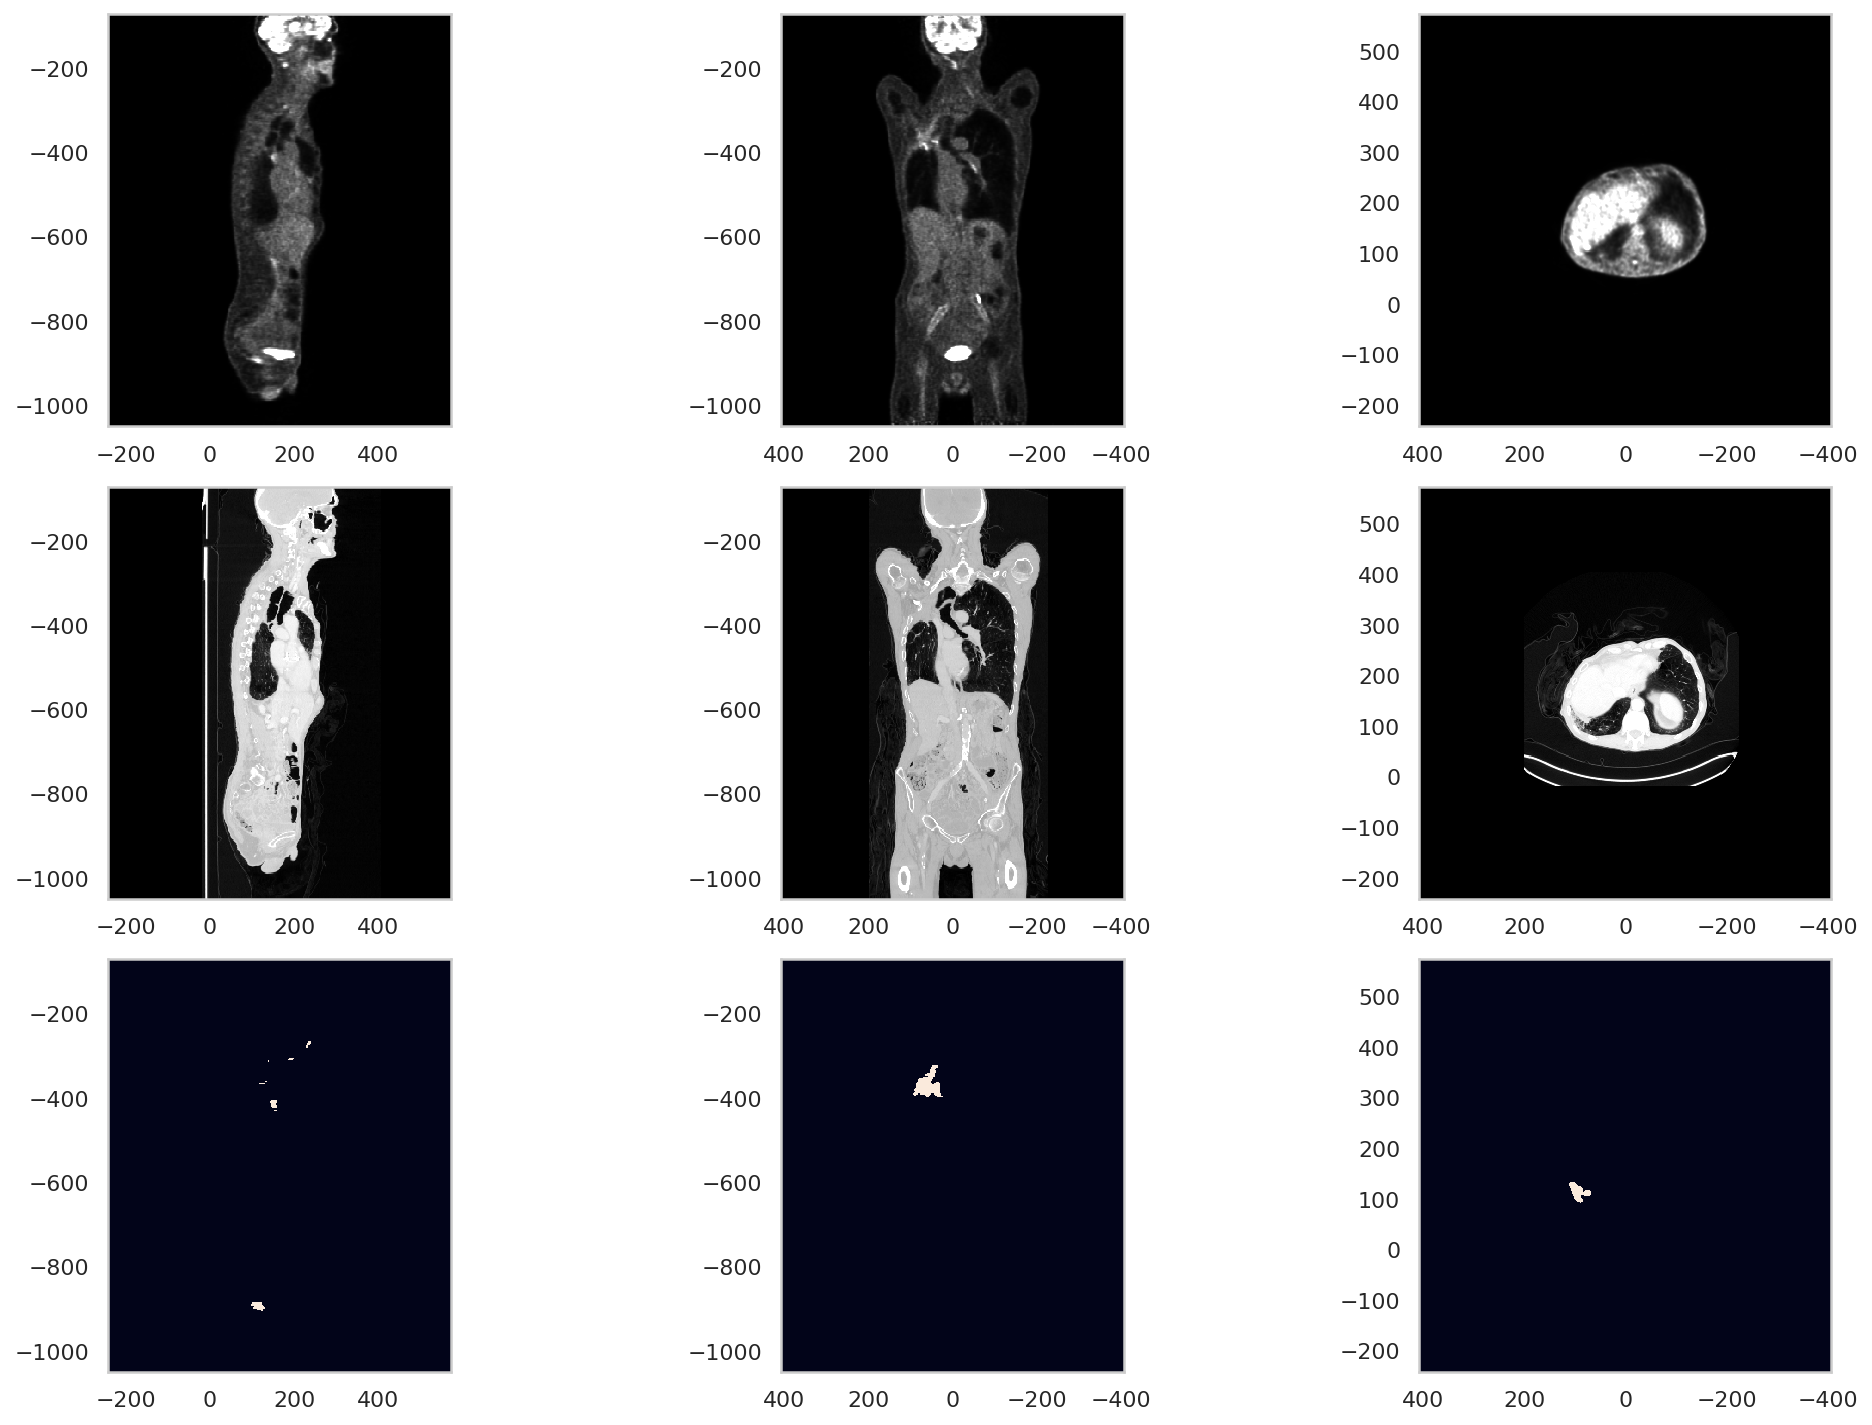

In [19]:
exam0 = dataset[350]
show_fpg(exam0)

# To canoncical

Old orientation: ('L', 'A', 'S')
New orientation: ('R', 'A', 'S')


/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


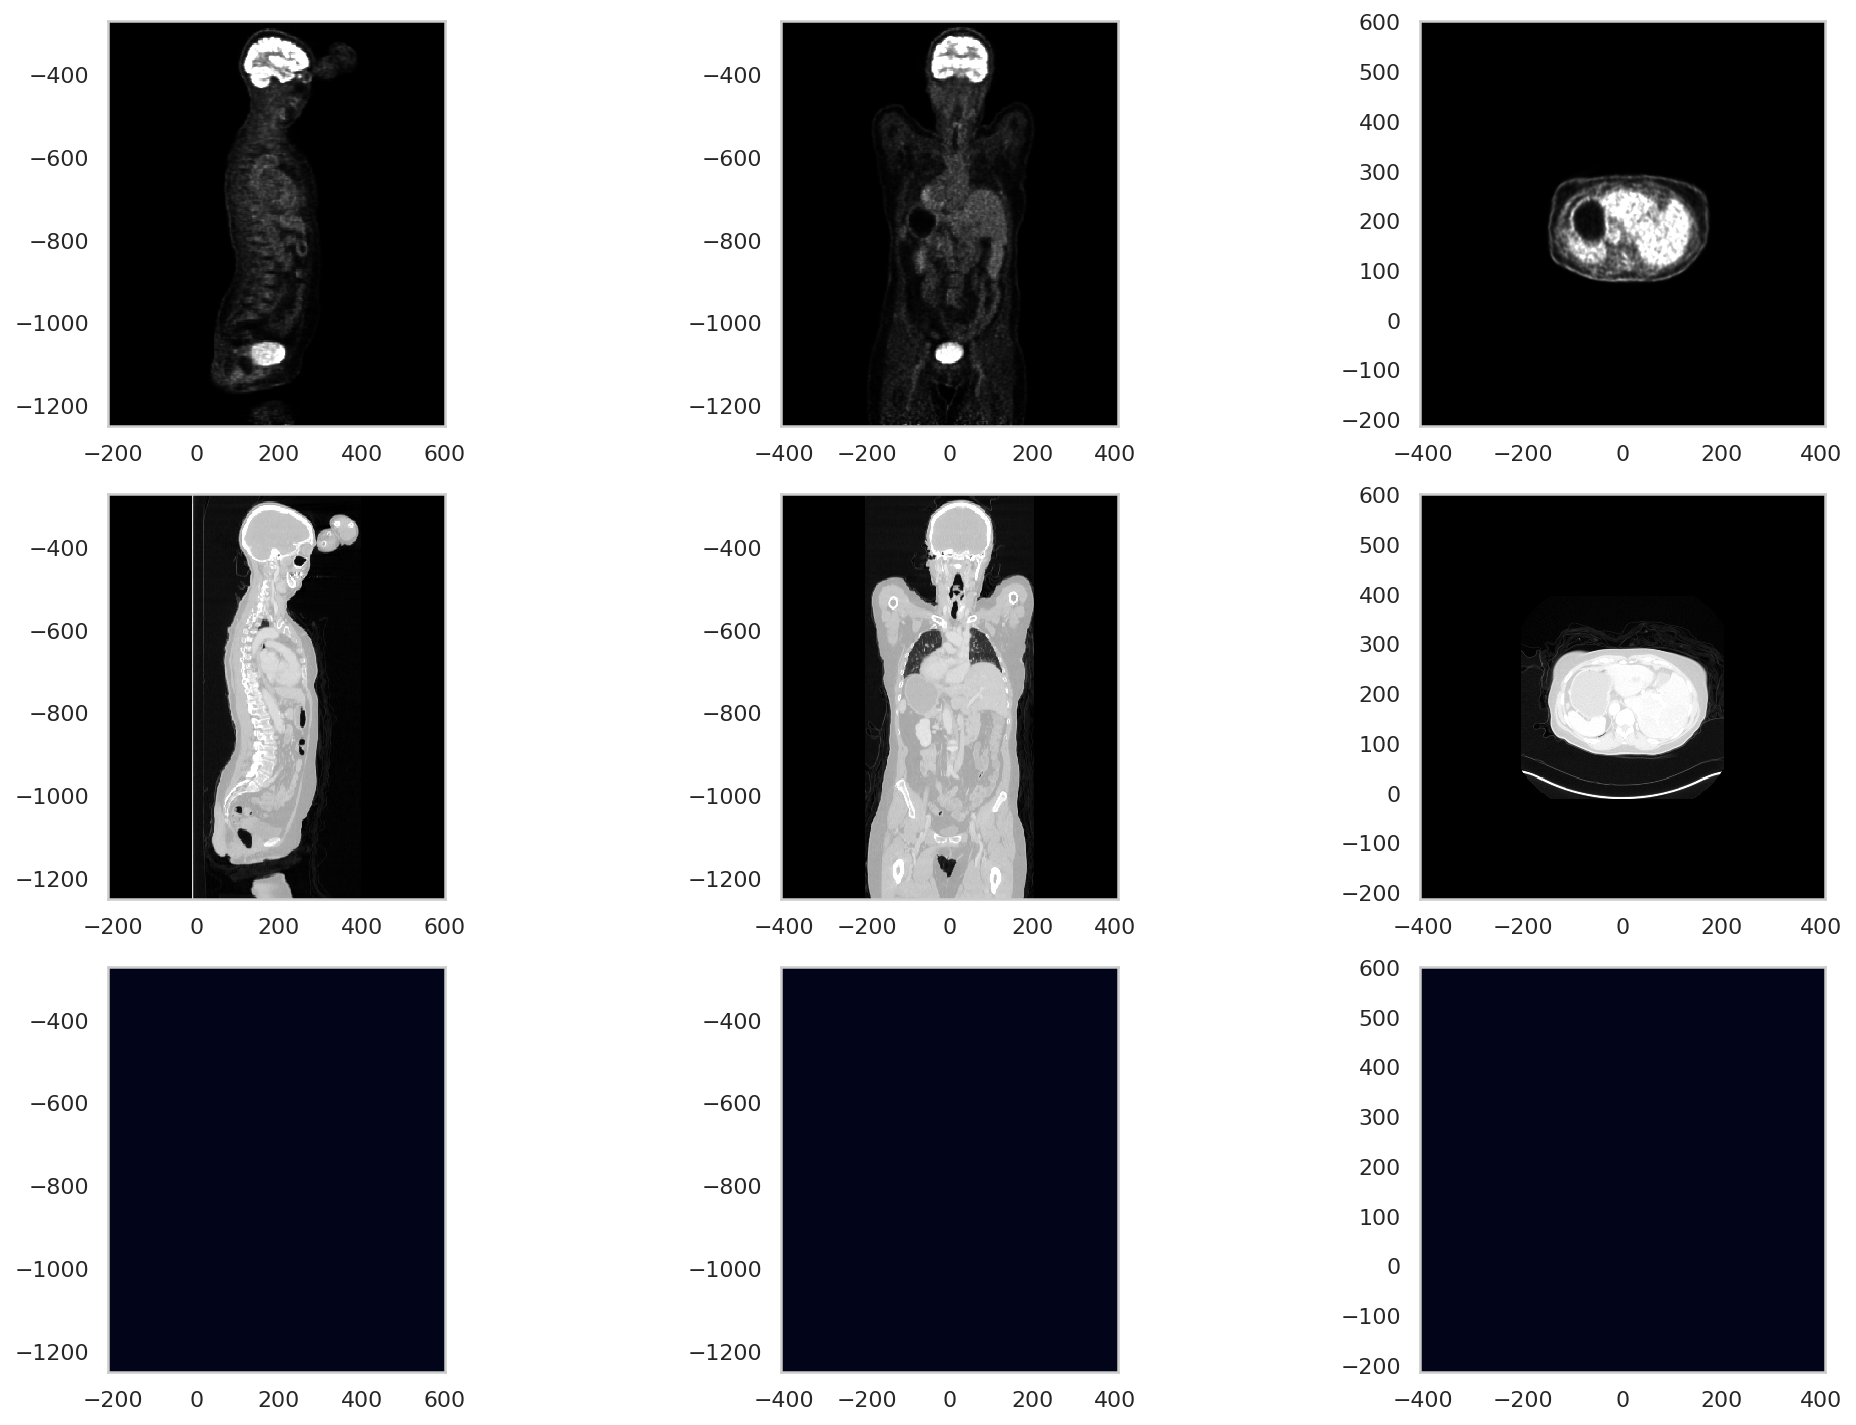

In [14]:
to_ras = tio.ToCanonical()
exam0_ras = to_ras(exam0)
print('Old orientation:', exam0.pet.orientation)
print('New orientation:', exam0_ras.pet.orientation)
show_fpg(exam0_ras)

# Resample


In [15]:
downsampling_factor = (3,3,3)
target_spacing = tuple(downsampling_factor[i] * exam0_ras.pet.spacing[i] for i in range(len(downsampling_factor)))# in mm

Original image: ScalarImage(shape: (1, 400, 400, 326); spacing: (2.04, 2.04, 3.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 199.0 MiB)
Downsampled image: ScalarImage(shape: (1, 134, 134, 109); spacing: (6.11, 6.11, 9.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 7.5 MiB)
The downsampled image takes 26.7 times less memory!


/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


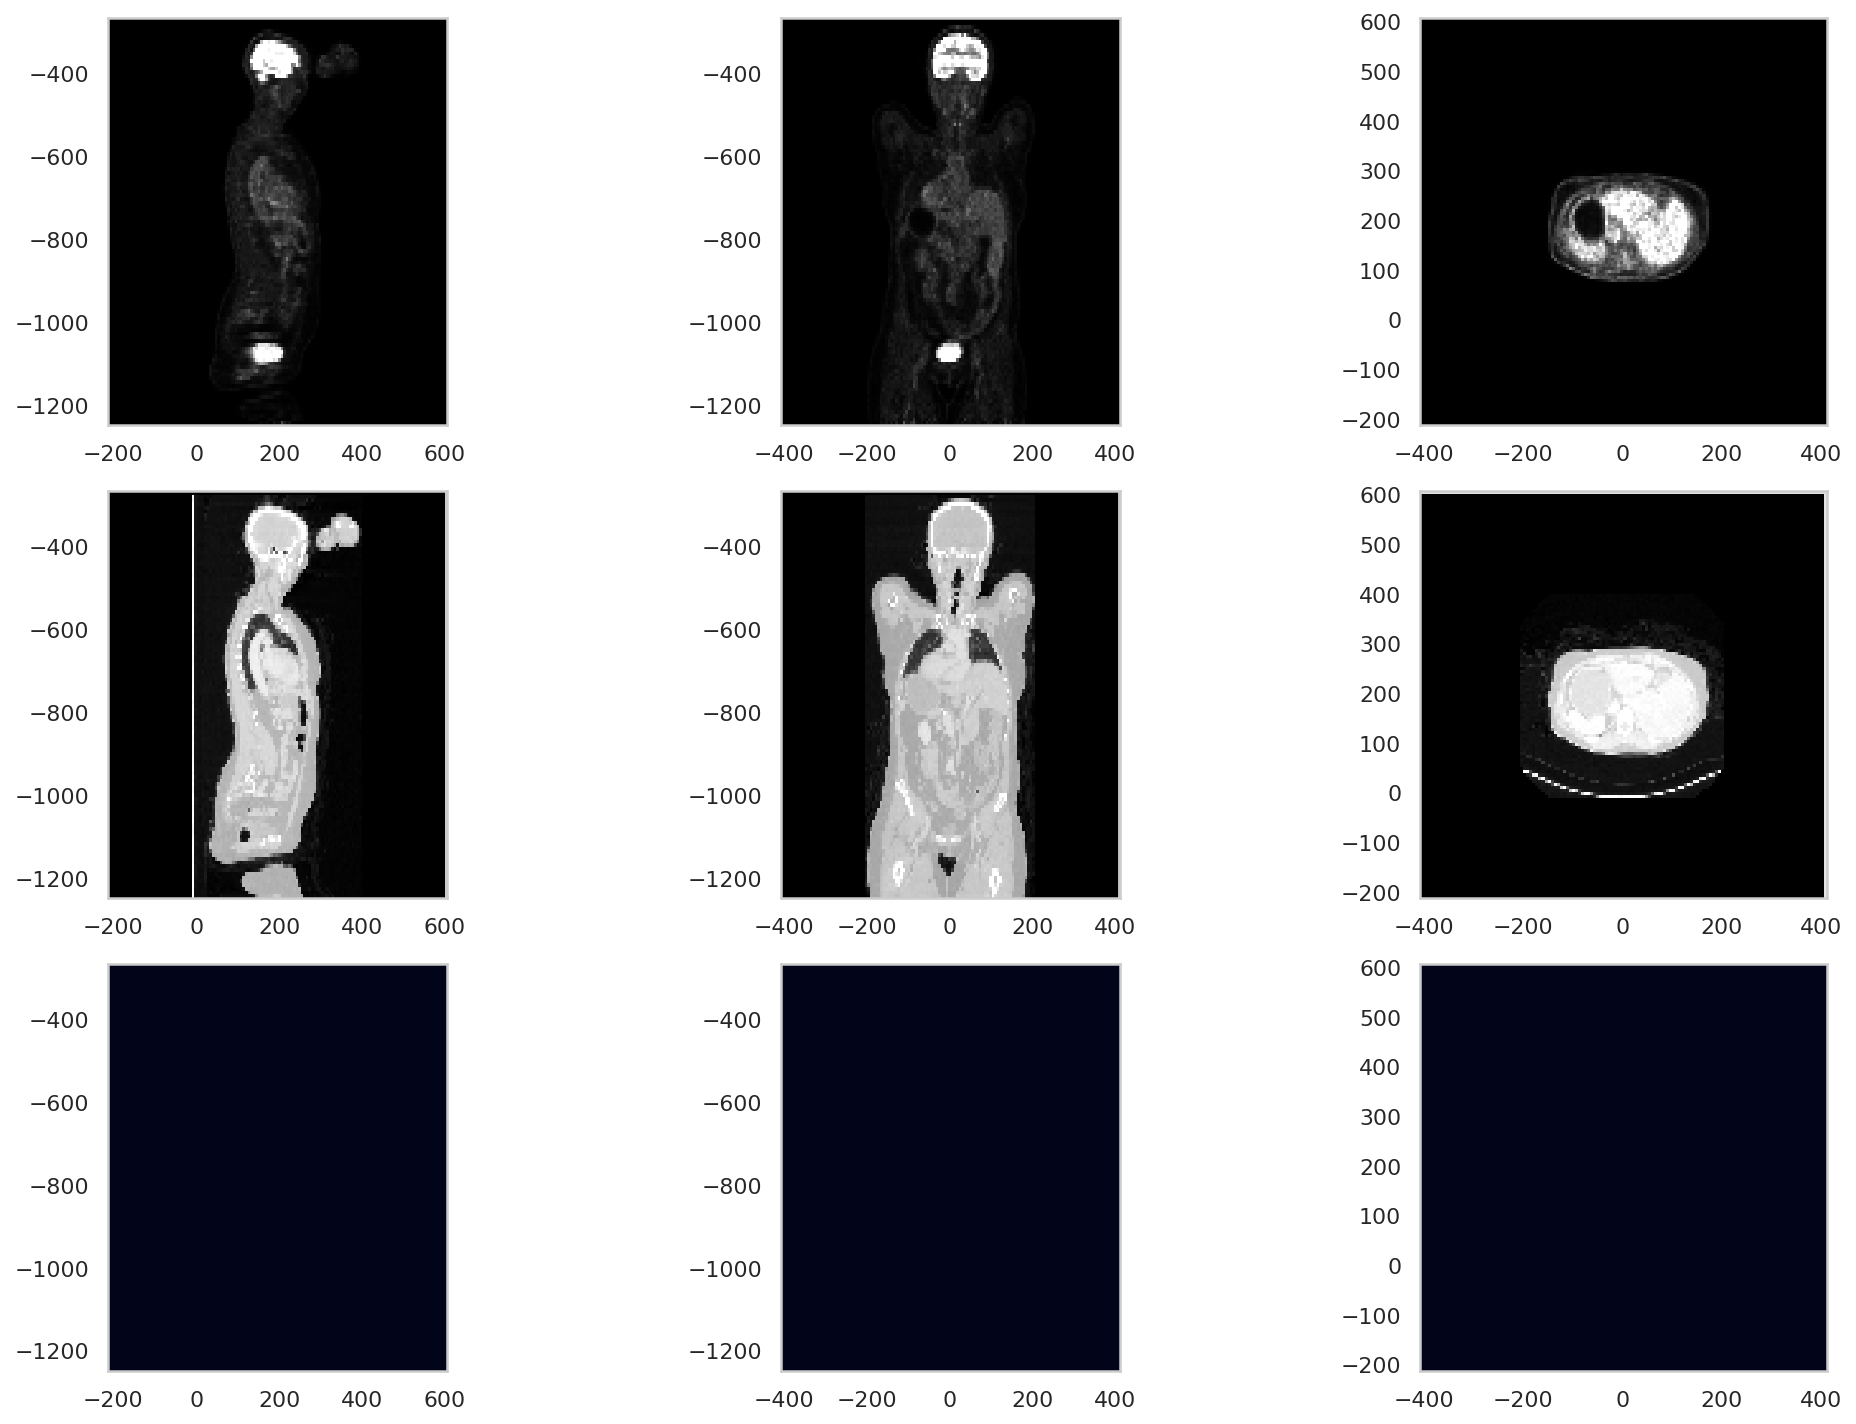

In [16]:
downsample = tio.Resample(target_spacing)
downsampled = downsample(exam0_ras)
print('Original image:', exam0_ras.pet)
print('Downsampled image:', downsampled.pet)
print(f'The downsampled image takes {exam0_ras.pet.memory / downsampled.pet.memory:.1f} times less memory!')
show_fpg(downsampled)

# Crop or pad

In [17]:
exam0_ras.pet.spatial_shape

(400, 400, 326)

/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


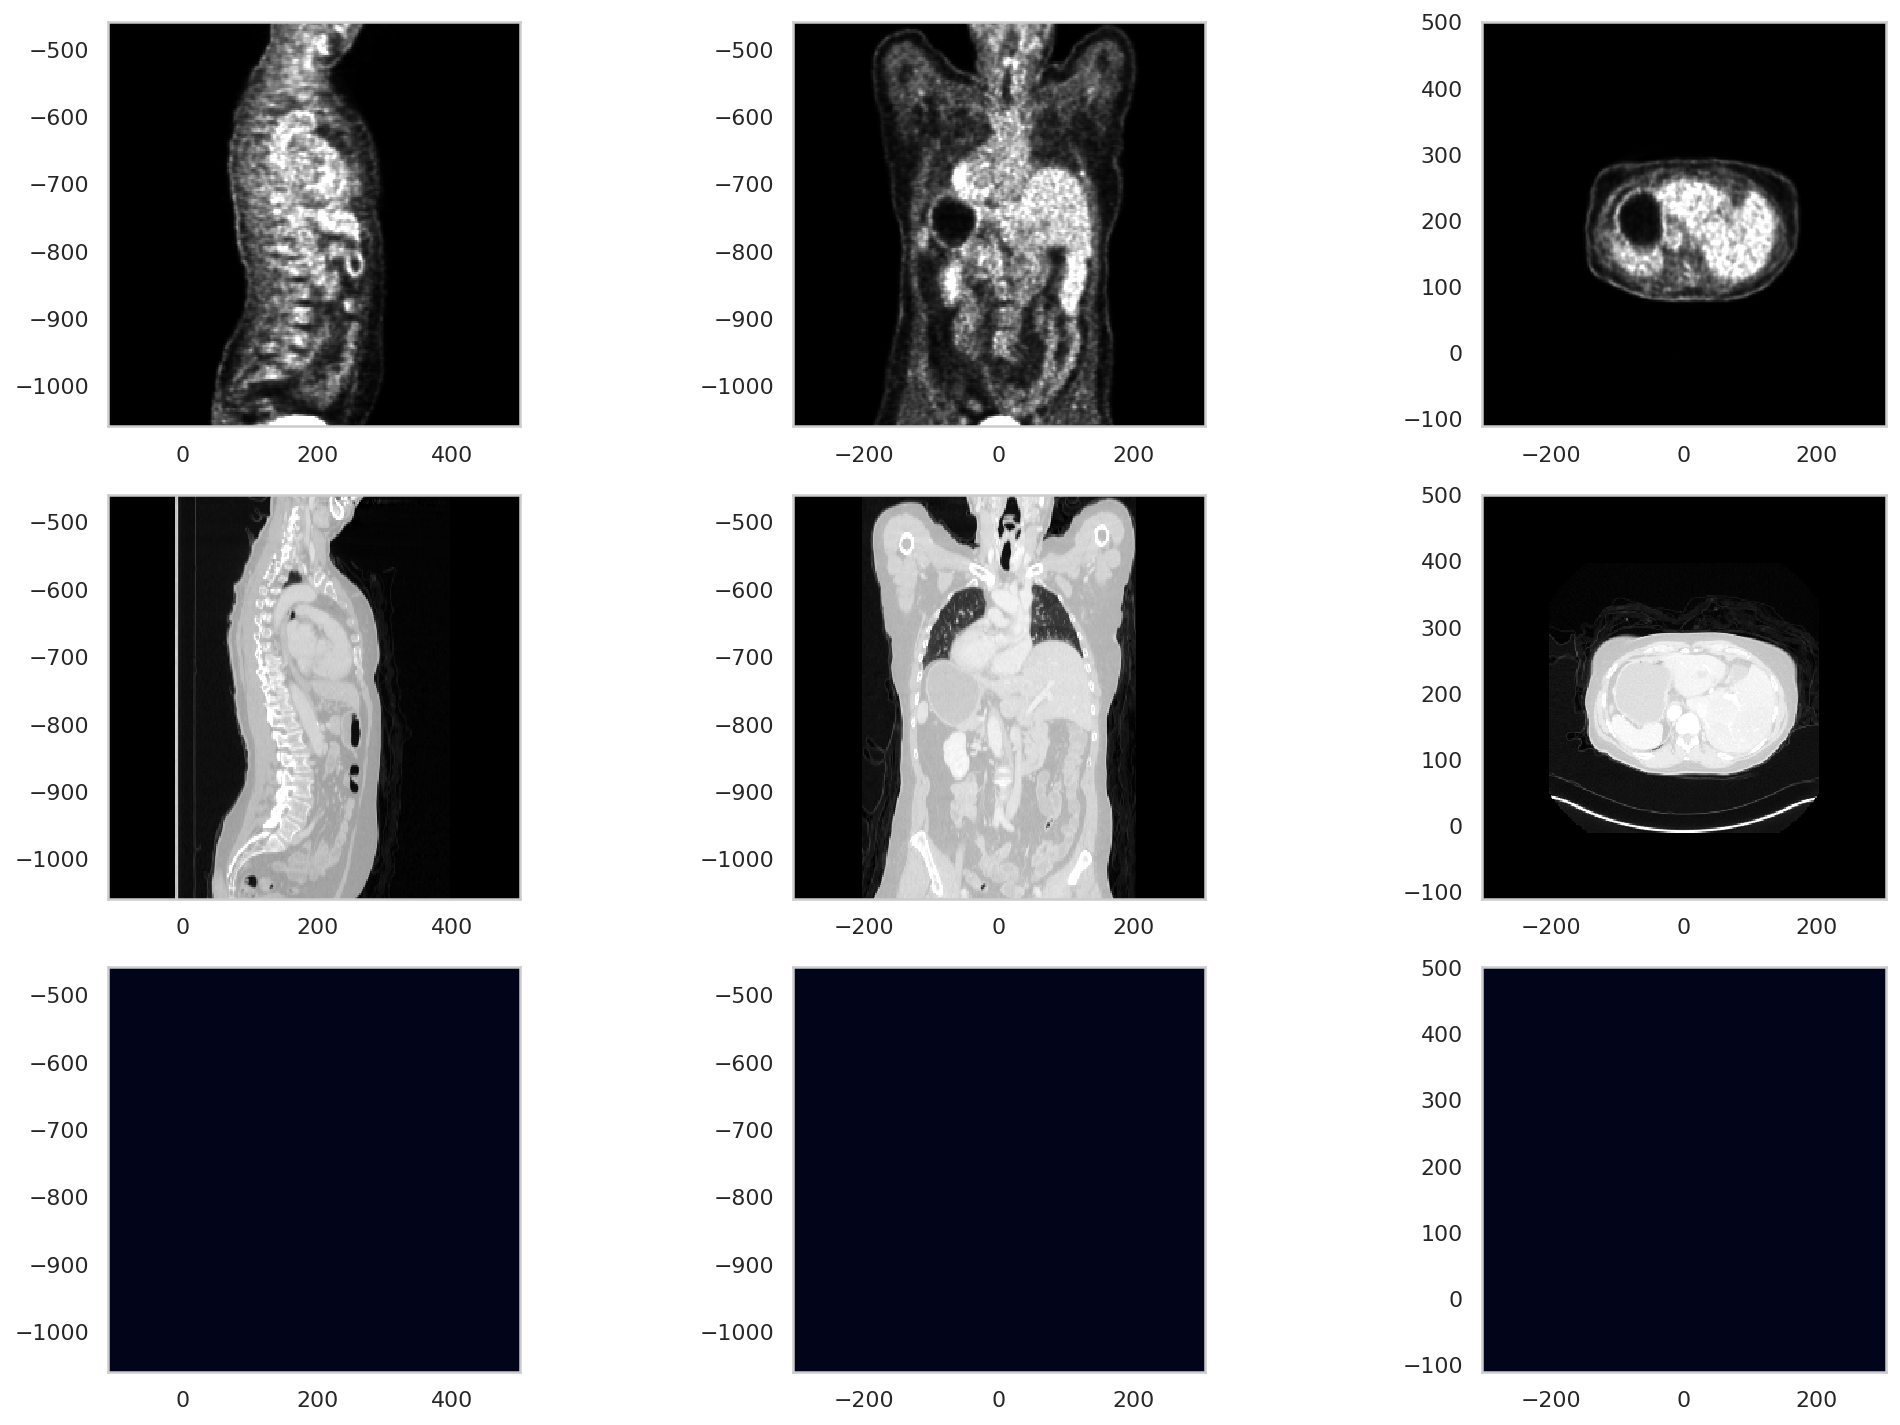

In [18]:
target_shape = 300, 300, 200
crop_pad = tio.CropOrPad(target_shape)
show_fpg(crop_pad(exam0_ras))

/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


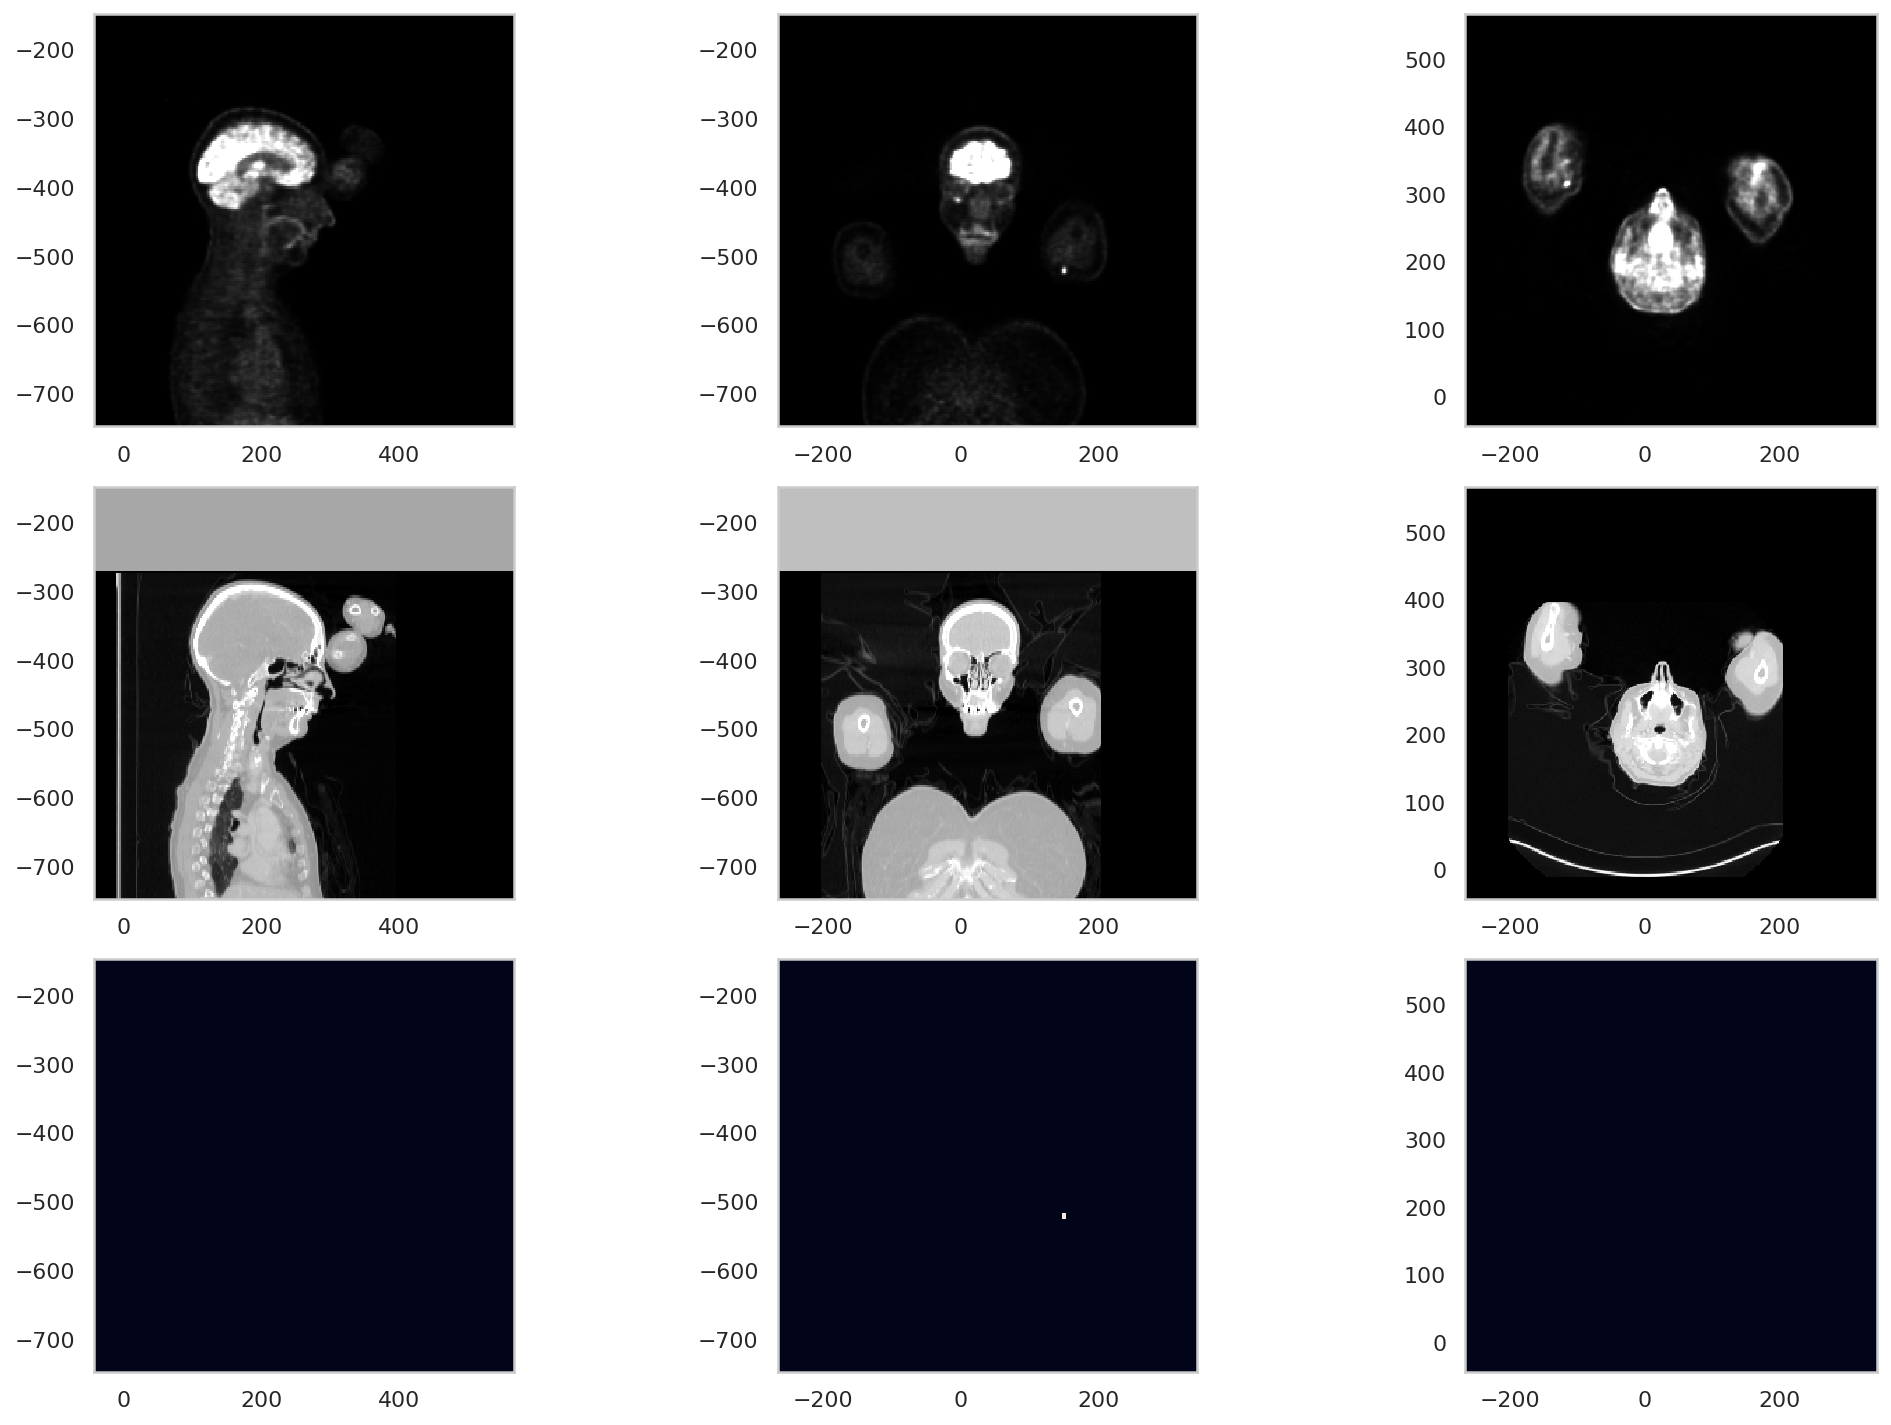

In [19]:
target_shape = 300, 300, 200
crop_pad = tio.CropOrPad(target_shape, mask_name='seg')
show_fpg(crop_pad(exam0_ras))

# Random anisotropy

Applied transforms:
[ToCanonical(),
 Resample(target=(2.0364201068878174, 4.003908942161729, 3.0), image_interpolation=nearest, label_interpolation=nearest, pre_affine_name=None, scalars_only=True),
 Resample(target=((400, 400, 326), array([[ 2.03642011e+00,  0.00000000e+00,  0.00000000e+00,
        -4.05793616e+02],
       [ 0.00000000e+00,  2.03642011e+00,  0.00000000e+00,
        -2.11548584e+02],
       [ 0.00000000e+00,  0.00000000e+00,  3.00000000e+00,
        -1.24700000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])), image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=True)]


/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


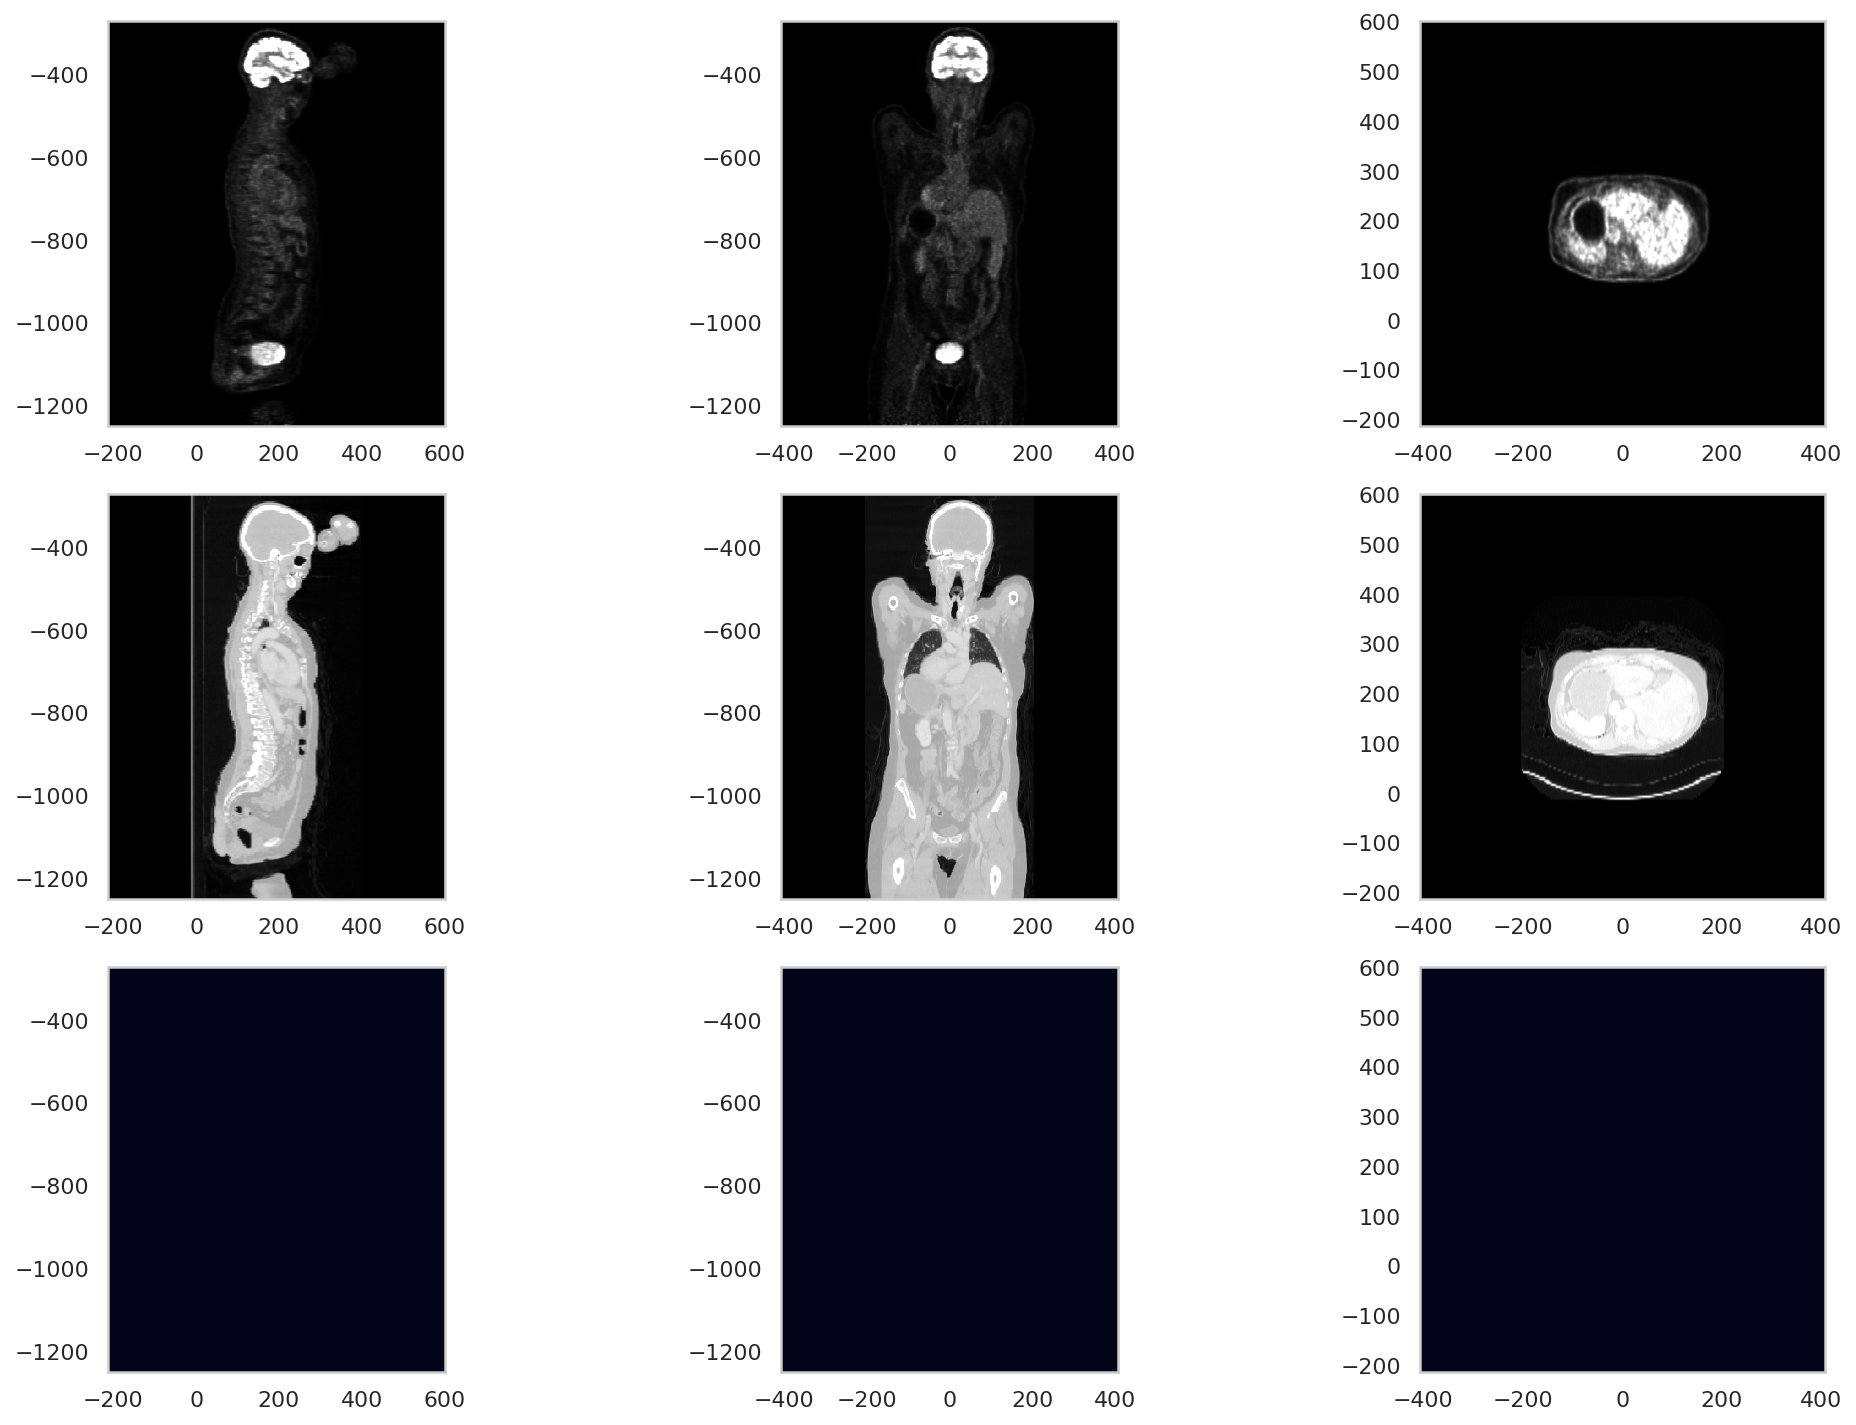

In [20]:
random_anisotropy = tio.RandomAnisotropy()
exam0_anisotropic = random_anisotropy(exam0_ras)
print('Applied transforms:')
pprint.pprint(exam0_anisotropic.history)
show_fpg(exam0_anisotropic)

# Random Affine

/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


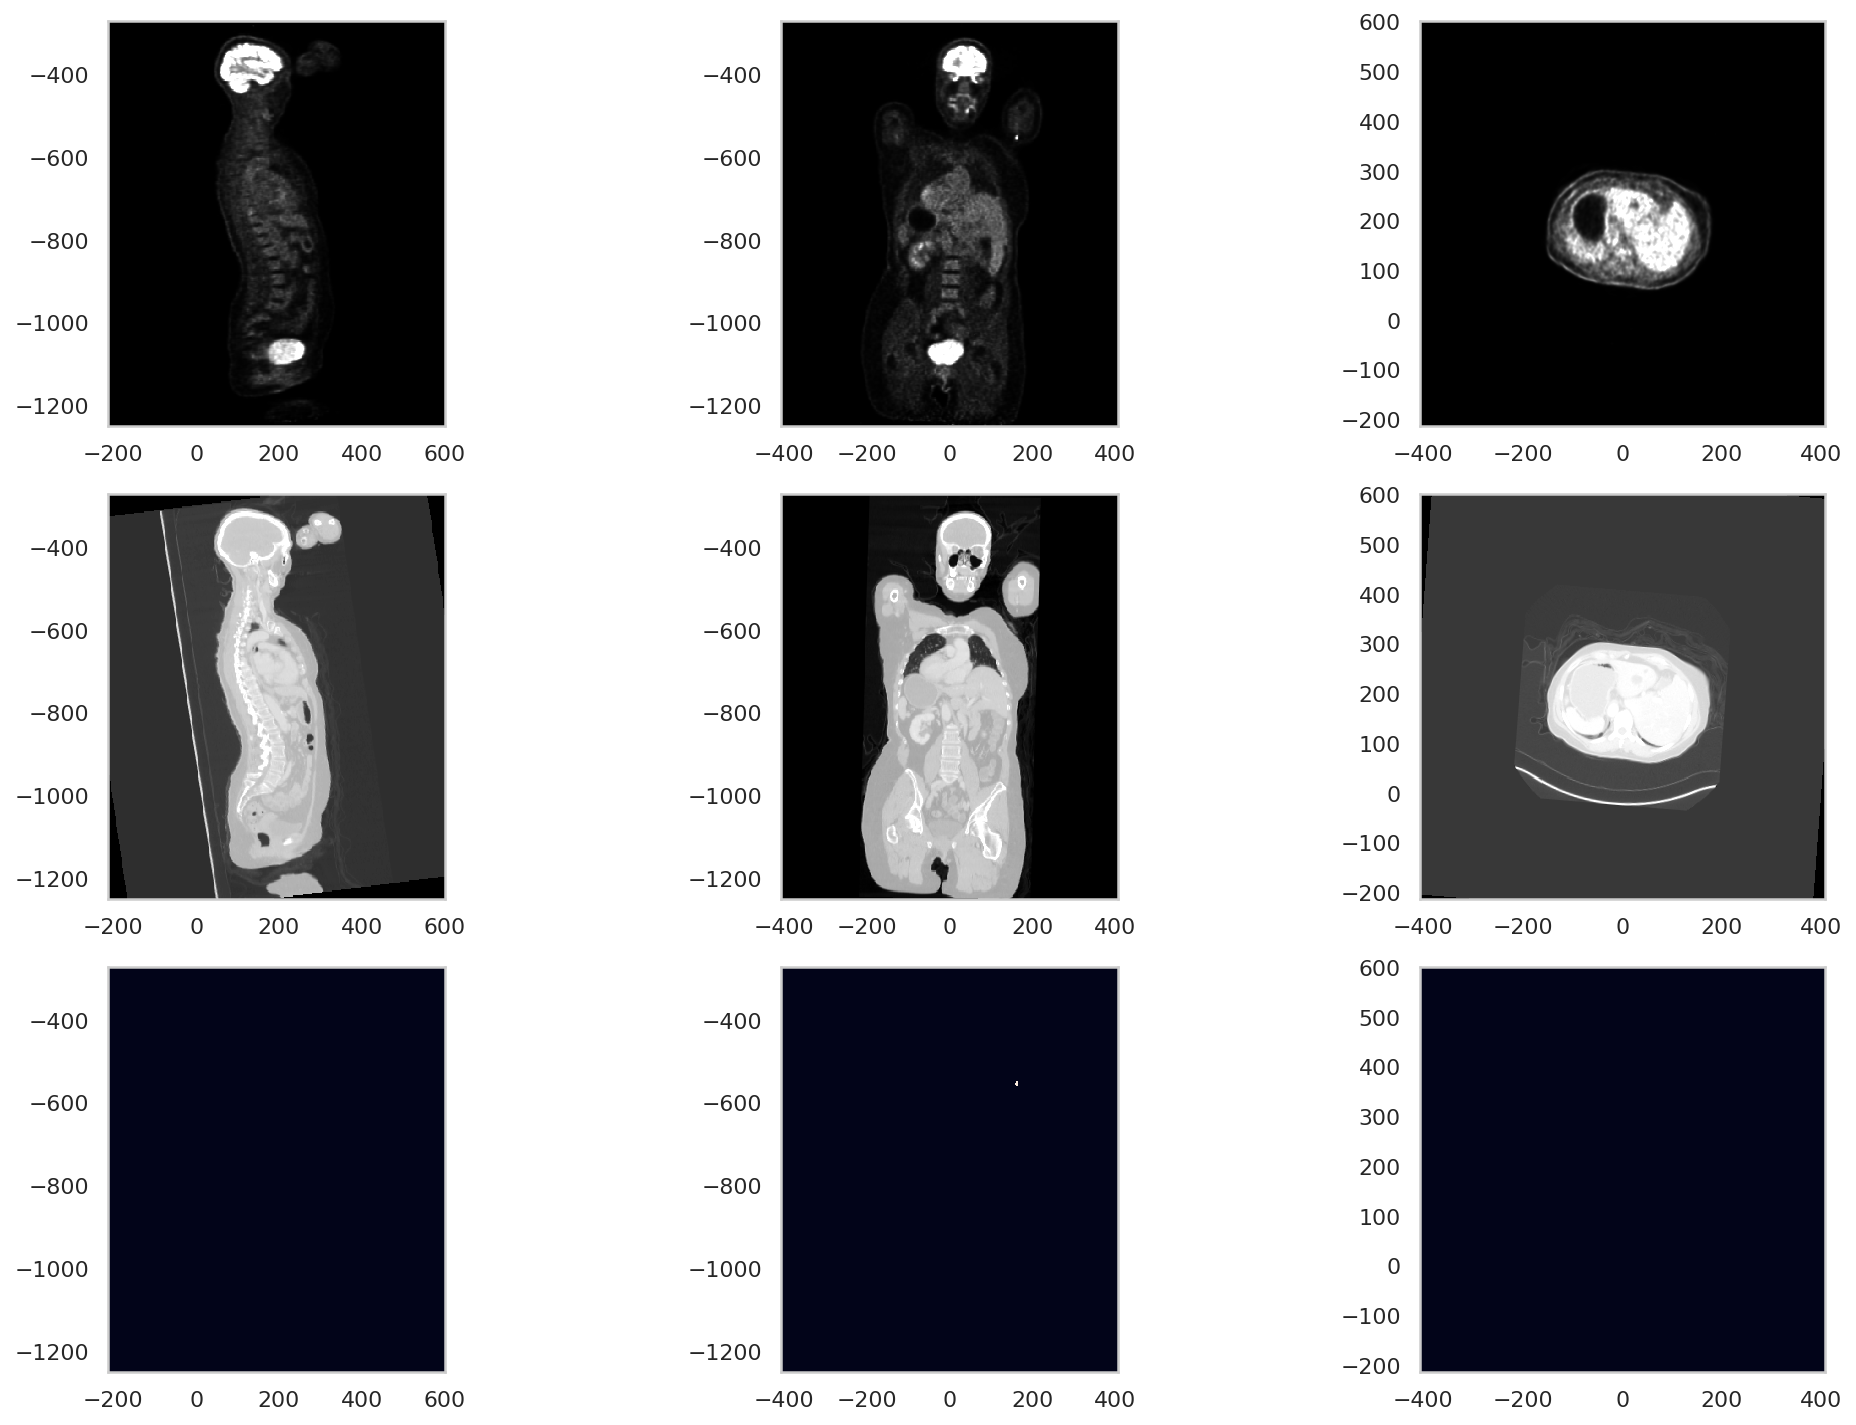

In [21]:
random_affine = tio.RandomAffine()
exam0_affine = random_affine(exam0_ras)
show_fpg(exam0_affine)

# Random flip

/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


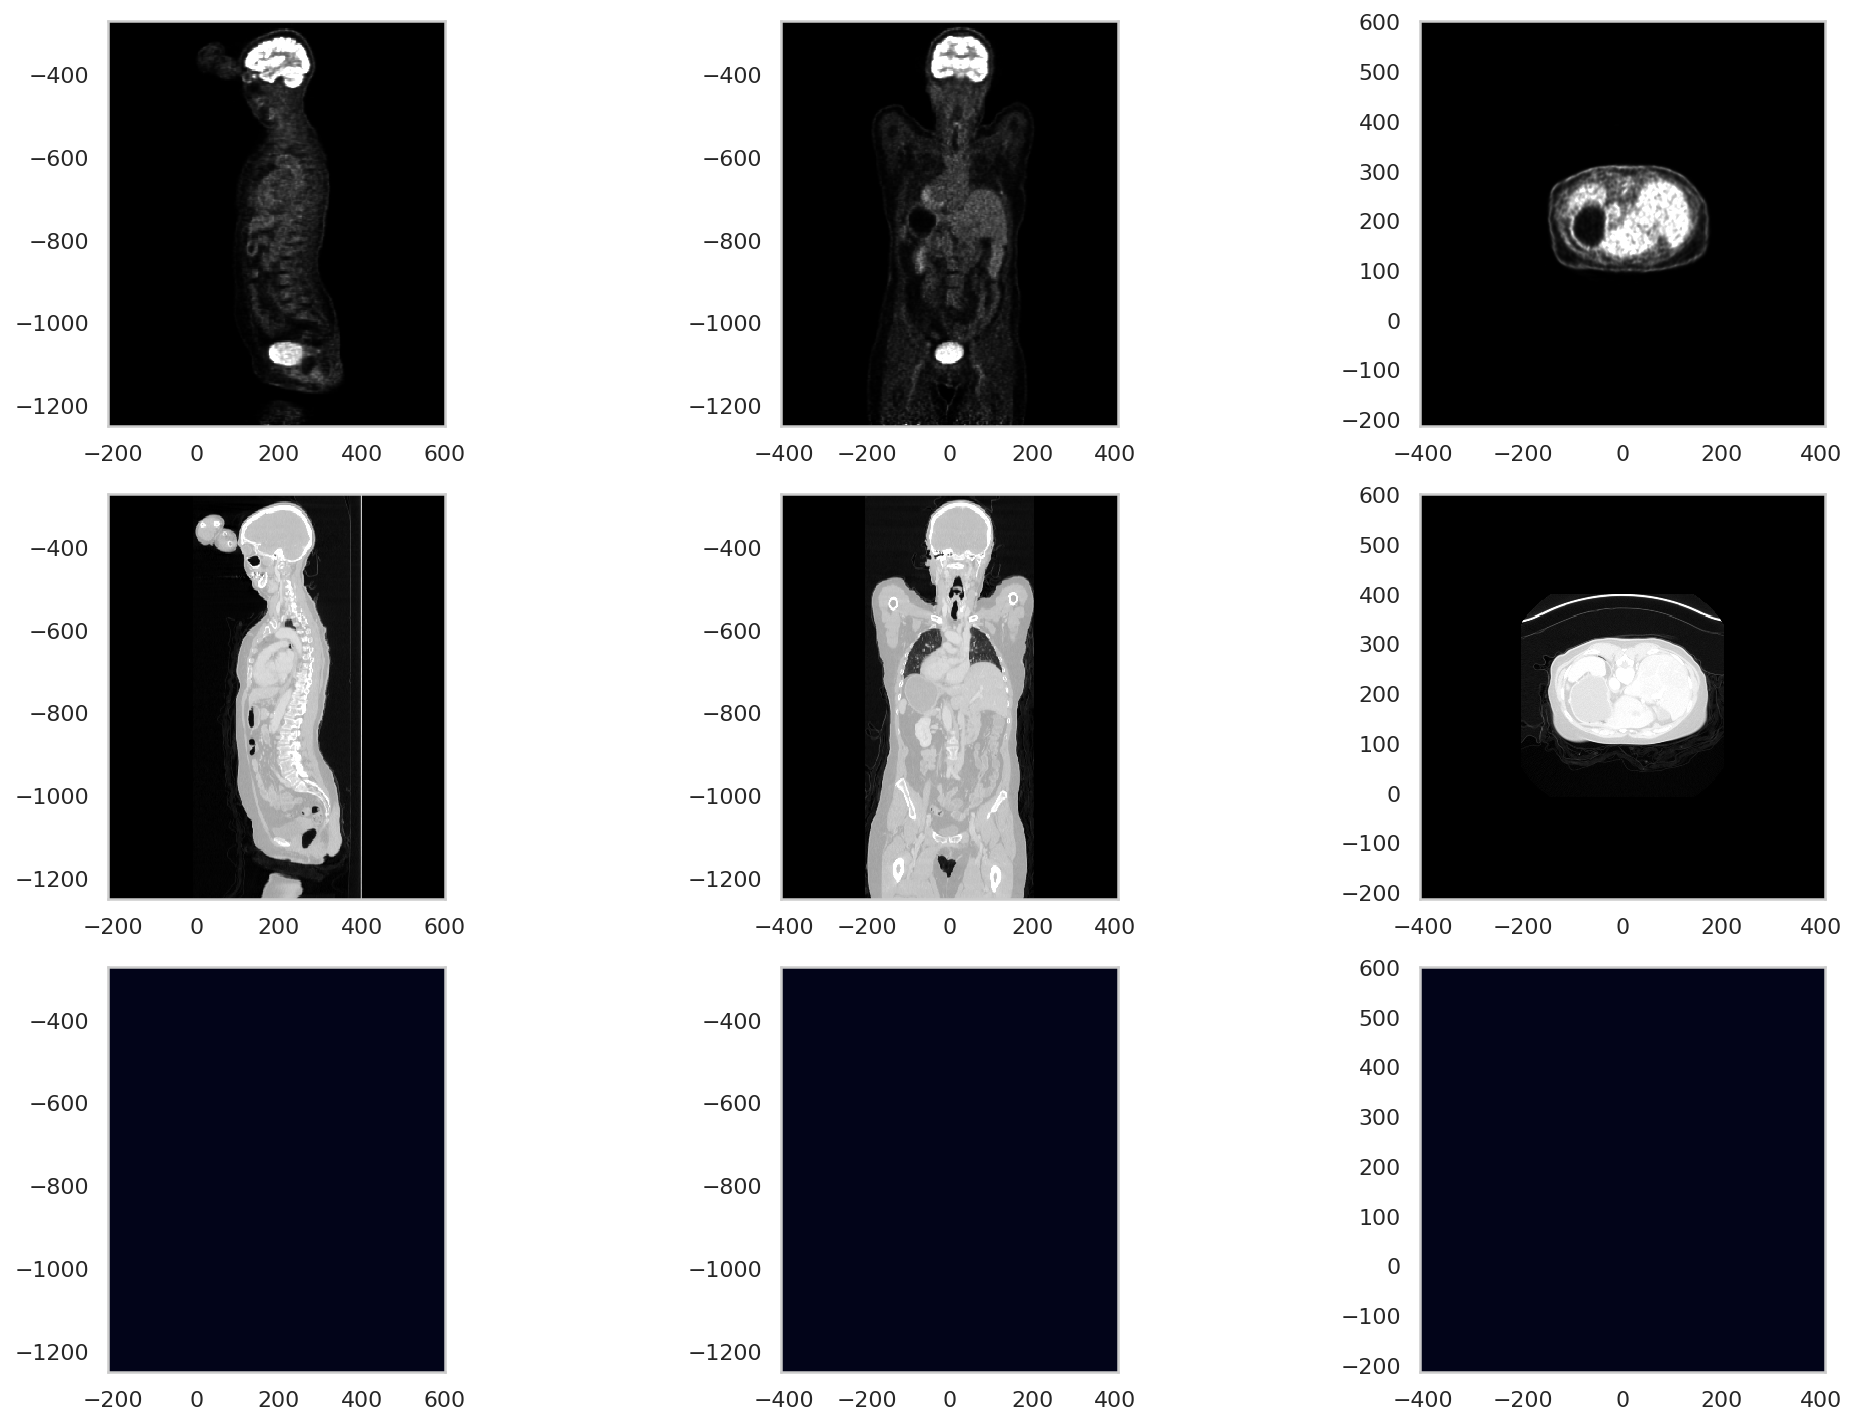

In [33]:
random_flip = tio.RandomFlip(axes=['anterior-posterior'], flip_probability=1)
exam0_flipped = random_flip(exam0_ras)
show_fpg(exam0_flipped)

# Random elastic deformation

/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


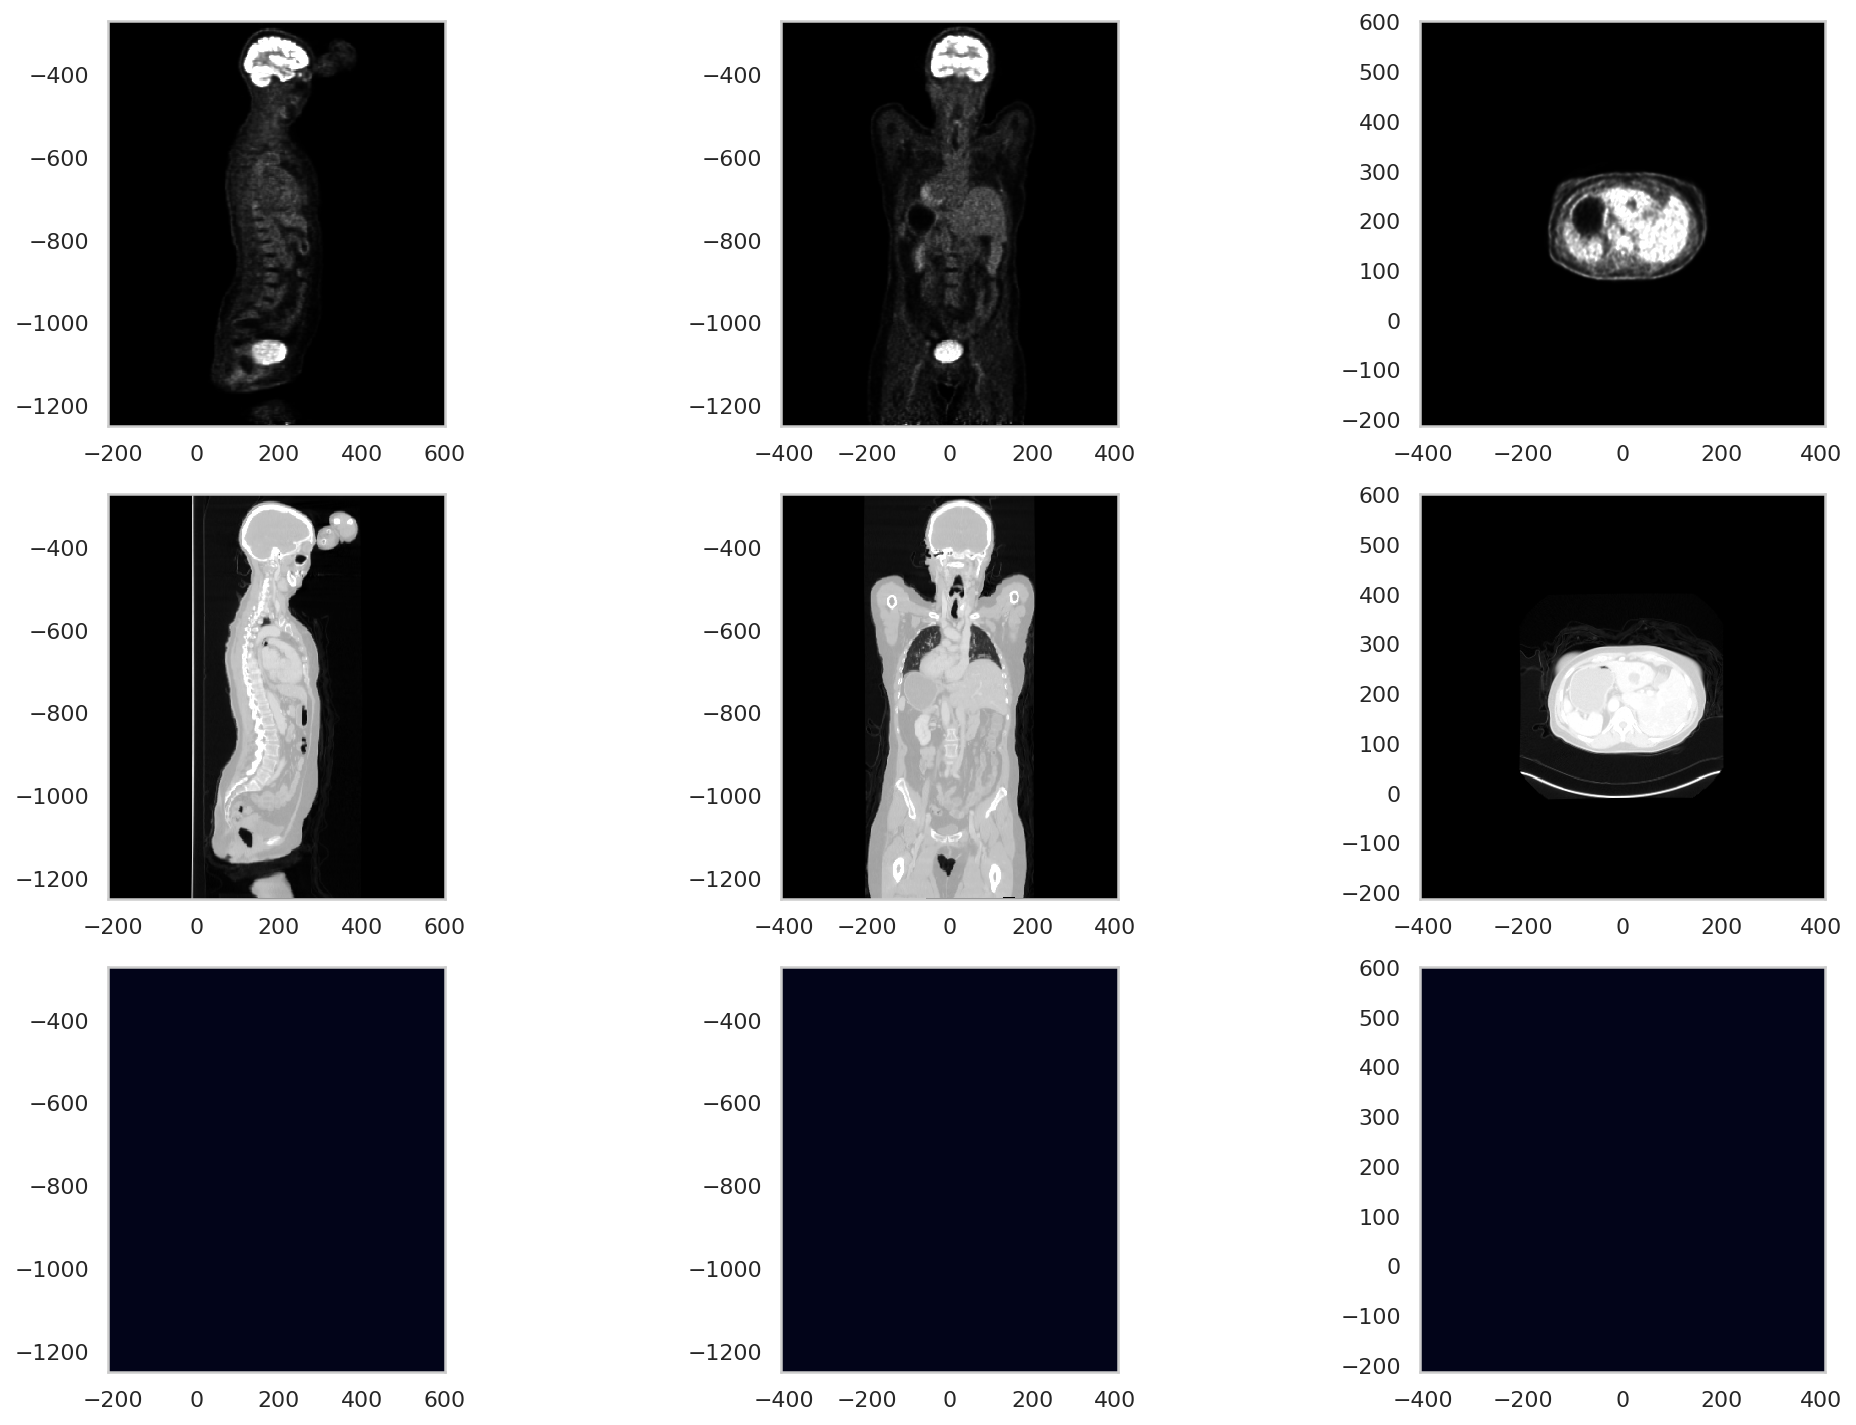

In [34]:
max_displacement = 15, 10, 15  # in x, y and z directions
random_elastic = tio.RandomElasticDeformation(max_displacement=max_displacement)
exam0_elastic = random_elastic(exam0_ras)
show_fpg(exam0_elastic)

/user/hschmutz/home/.local/lib/python3.9/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [0, 1, 2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(
/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


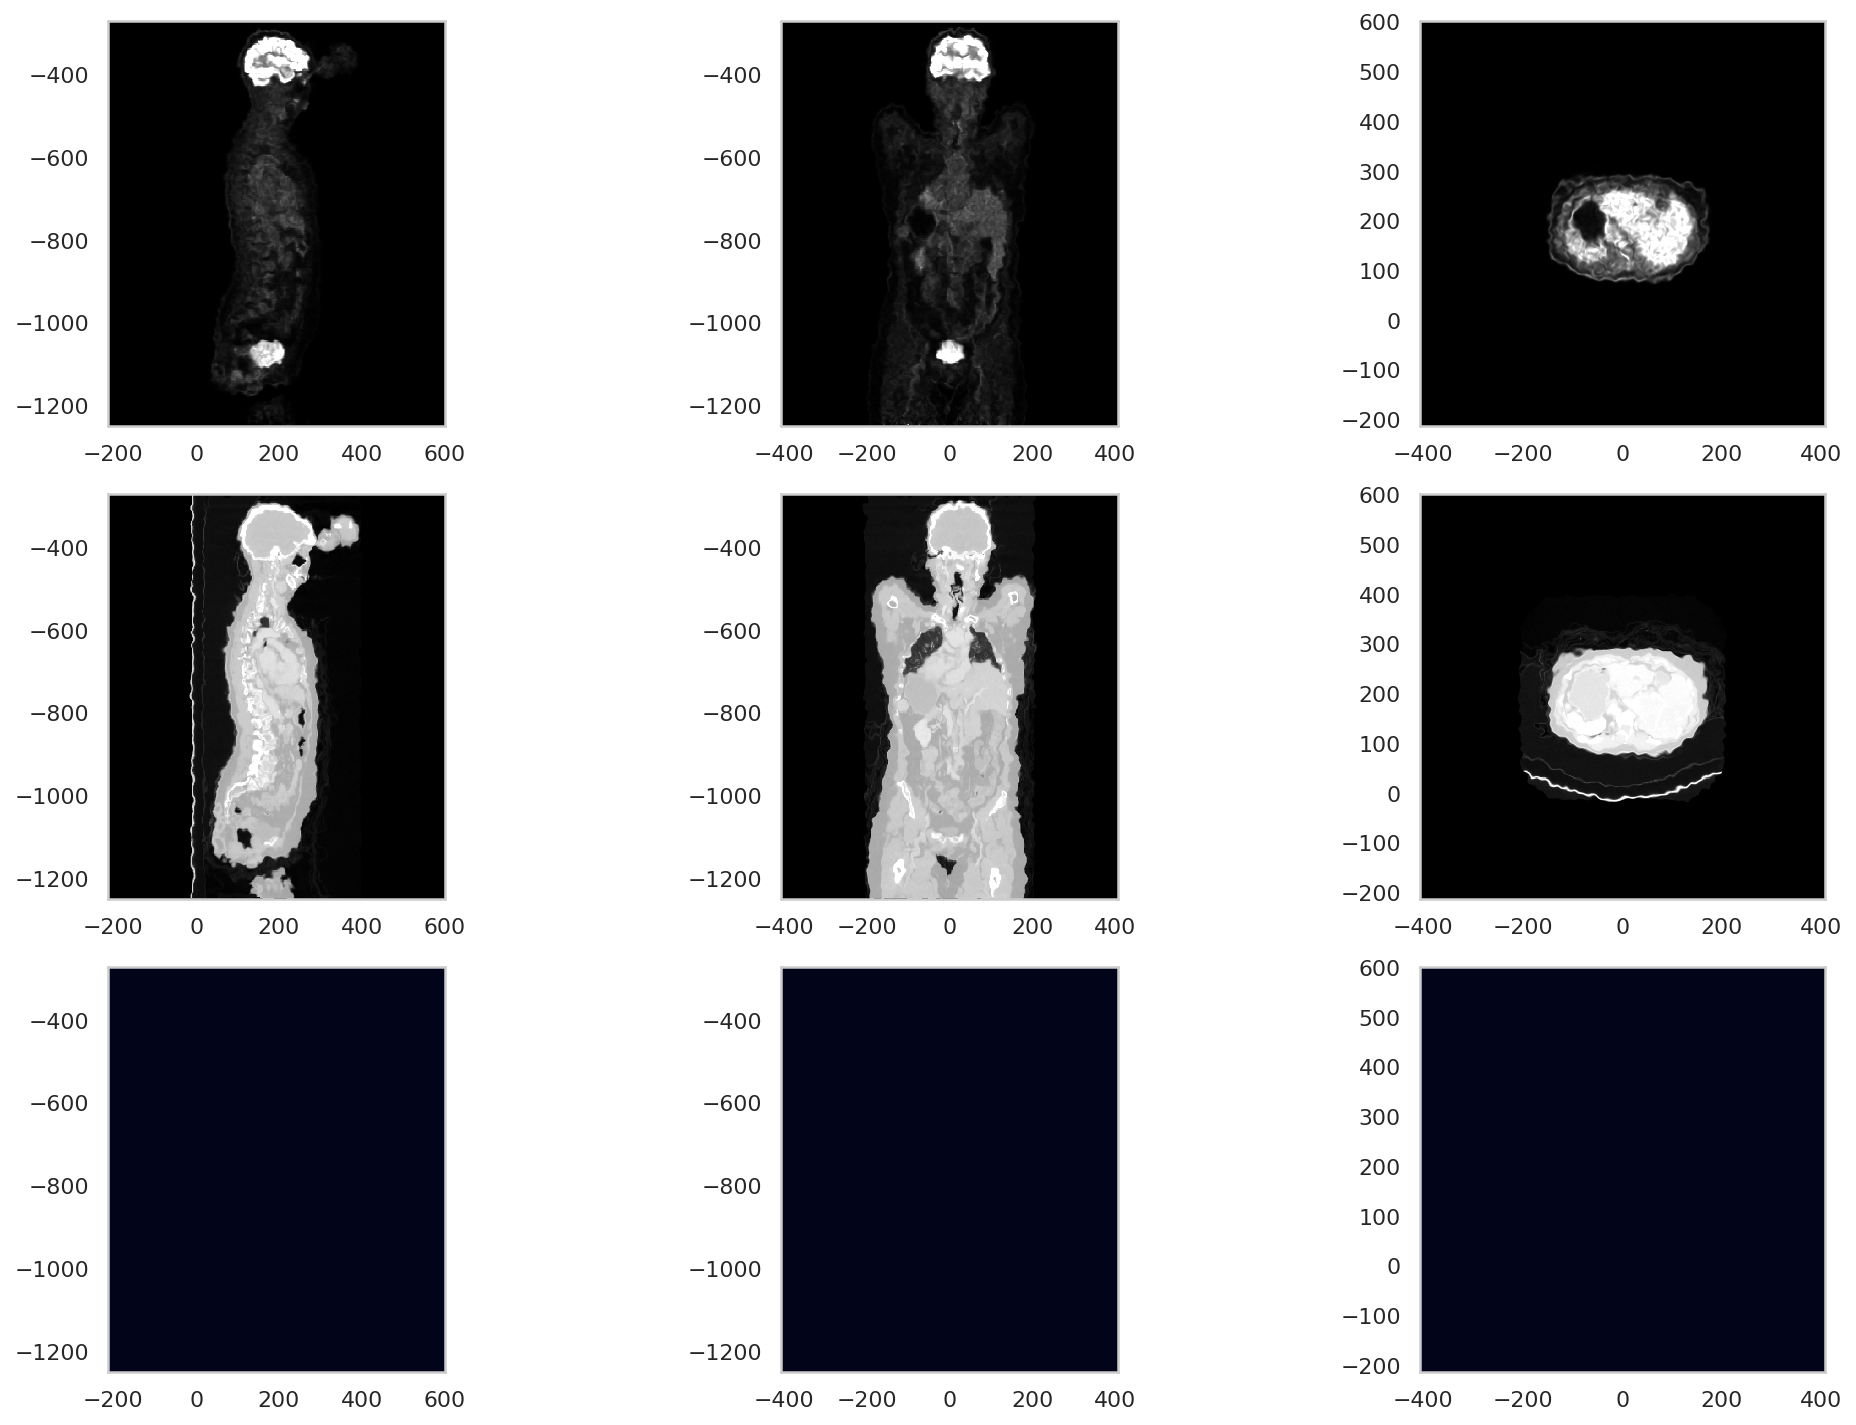

In [35]:
max_displacement = 15, 10, 15  # in x, y and z directions
random_elastic = tio.RandomElasticDeformation(max_displacement=max_displacement,    num_control_points=100)
exam0_elastic = random_elastic(exam0_ras)
show_fpg(exam0_elastic)

/tmp/ipykernel_30959/1195157713.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_shape = torch.Tensor(subject.spatial_shape) // 2


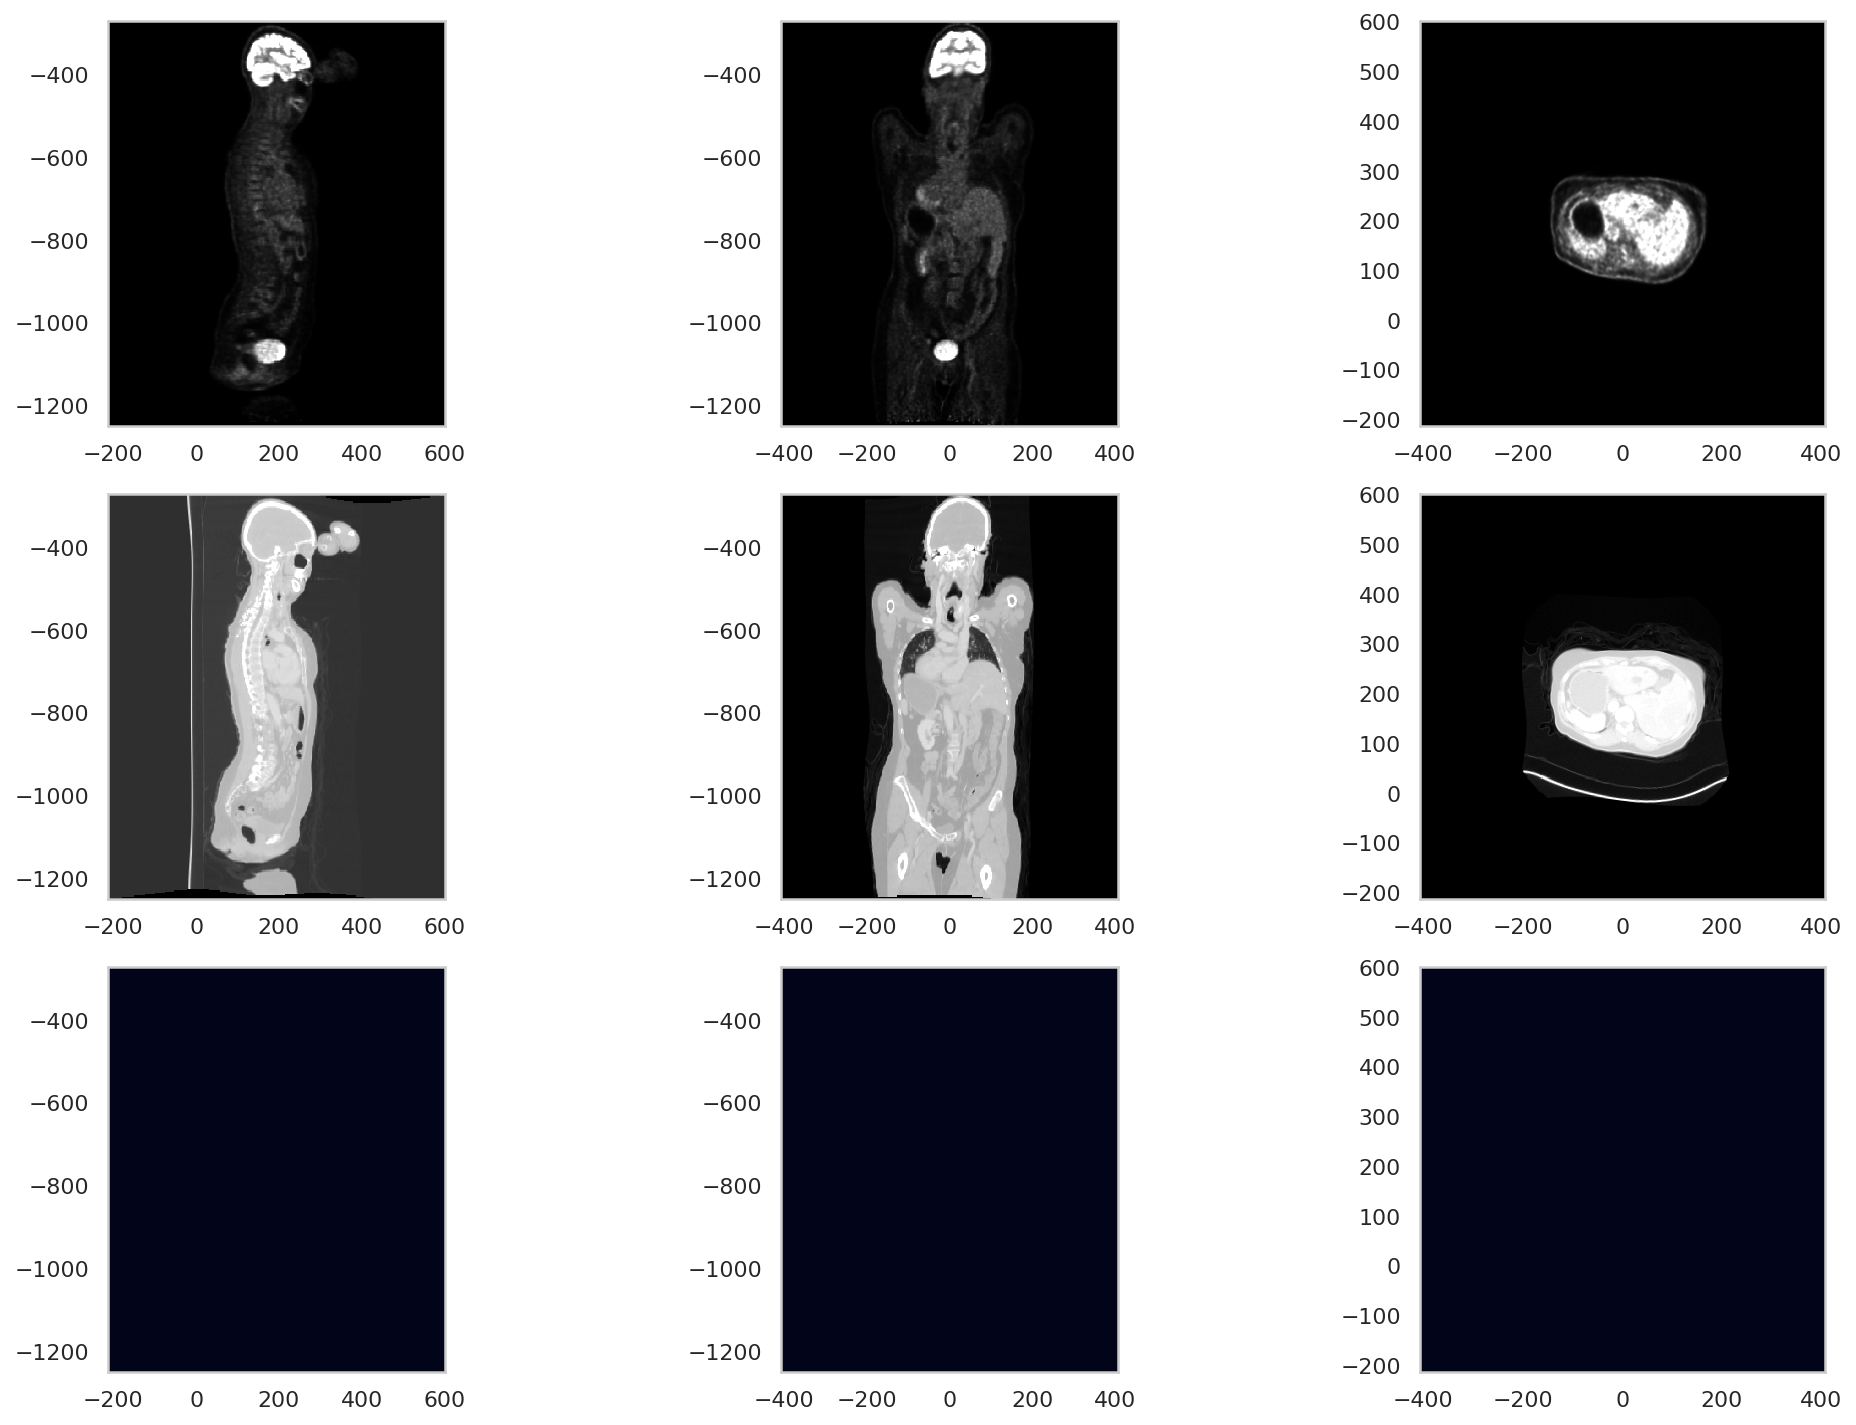

In [37]:
max_displacement = 15, 10, 15  # in x, y and z directions
random_elastic = tio.RandomElasticDeformation(max_displacement=3*np.array(max_displacement),    num_control_points=10)
exam0_elastic = random_elastic(exam0_ras)
show_fpg(exam0_elastic)

/user/hschmutz/home/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


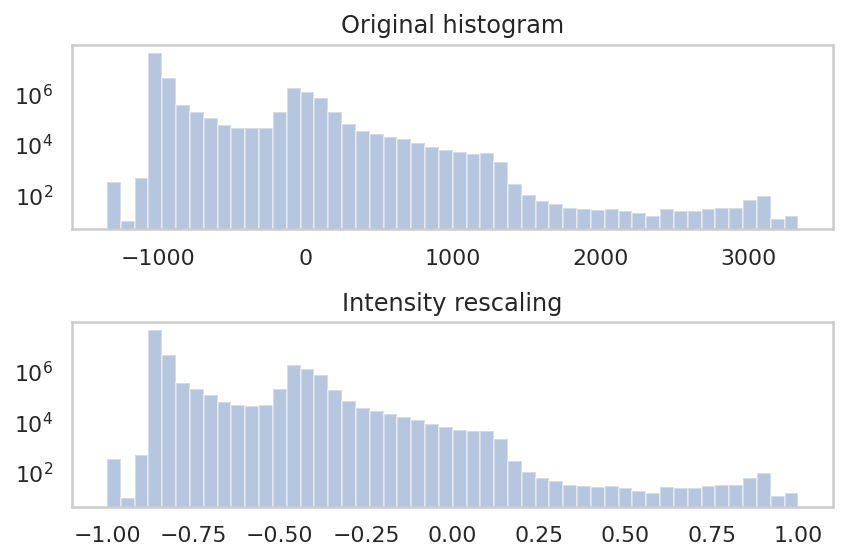

In [43]:
rescale = tio.RescaleIntensity((-1, 1))
rescaled = rescale(exam0_ras)
fig, axes = plt.subplots(2, 1)
sns.distplot(exam0_ras.ct.data, ax=axes[0], kde=False)
sns.distplot(rescaled.ct.data, ax=axes[1], kde=False)
axes[0].set_title('Original histogram')
axes[1].set_title('Intensity rescaling')

axes[0].set_yscale('log')
axes[1].set_yscale('log')
plt.tight_layout()